In [1]:
# 한글 폰트 설치하기 (꼭! 설치가 완료되면 [런타임 다시 시작]을 누르고 다시 실행하기)
!apt install fonts-nanum -y

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정하기
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
plt.rc('font', family='NanumBarunGothic')
matplotlib.font_manager._rebuild()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [2]:
# 필요한 라이브러리 설치하기
!git clone https://github.com/ndb796/bing_image_downloader

Cloning into 'bing_image_downloader'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 86 (delta 38), reused 46 (delta 16), pack-reused 0
Unpacking objects: 100% (86/86), done.


In [3]:
import os
import shutil
from bing_image_downloader.bing_image_downloader import downloader


directory_list = [
    './custom_dataset/train/',
    './custom_dataset/test/',
]

# 초기 디렉토리 만들기
for directory in directory_list:
    if not os.path.isdir(directory):
        os.makedirs(directory)

# 수집한 이미지를 학습 데이터와 평가 데이터로 구분하는 함수
def dataset_split(query, train_cnt):
    # 학습 및 평가 데이터셋 디렉토리 만들기
    for directory in directory_list:
        if not os.path.isdir(directory + '/' + query):
            os.makedirs(directory + '/' + query)
    # 학습 및 평가 데이터셋 준비하기
    cnt = 0
    for file_name in os.listdir(query):
        if cnt < train_cnt:
            print(f'[Train Dataset] {file_name}')
            shutil.move(query + '/' + file_name, './custom_dataset/train/' + query + '/' + file_name)
        else:
            print(f'[Test Dataset] {file_name}')
            shutil.move(query + '/' + file_name, './custom_dataset/test/' + query + '/' + file_name)
        cnt += 1
    shutil.rmtree(query)

In [4]:
query = '장미 흰가루병'
downloader.download(query, limit=20,  output_dir='./', adult_filter_off=True, force_replace=False, timeout=60)
dataset_split(query, 8)

query = '장미 검은무늬병'
downloader.download(query, limit=20,  output_dir='./', adult_filter_off=True, force_replace=False, timeout=60)
dataset_split(query, 8)

query = '장미 점박이응애'
downloader.download(query, limit=20,  output_dir='./', adult_filter_off=True, force_replace=False, timeout=60)
dataset_split(query, 8)

[Info] Indexing page: 1
[Info] Indexed 20 Images on Page 1.
#1 이미지 다운로드 (http://cfs10.blog.daum.net/upload_control/download.blog?fhandle=MDdyQzdAZnMxMC5ibG9nLmRhdW0ubmV0Oi9JTUFHRS8wLzUuanBn&amp;filename=5.jpg)
#1 파일 다운로드가 완료되었습니다.
#2 이미지 다운로드 (http://cfs9.blog.daum.net/upload_control/download.blog?fhandle=MDdyQzdAZnM5LmJsb2cuZGF1bS5uZXQ6L0lNQUdFLzAvMTAuanBn&amp;filename=10.jpg)
#2 파일 다운로드가 완료되었습니다.
#3 이미지 다운로드 (http://cfs9.blog.daum.net/upload_control/download.blog?fhandle=MDdyQzdAZnM5LmJsb2cuZGF1bS5uZXQ6L0lNQUdFLzAvOS5qcGc=&amp;filename=9.jpg)
#3 파일 다운로드가 완료되었습니다.
#4 이미지 다운로드 (http://cfile222.uf.daum.net/image/1252CA3F4F4334A43EE662)
#4 파일 다운로드가 완료되었습니다.
#5 이미지 다운로드 (http://blogthumb2.naver.net/20120607_290/55mg_13390394006348GG1V_JPEG/20120607-5.jpg?type=w2)
#5 파일 다운로드가 완료되었습니다.
#6 이미지 다운로드 (https://i.ytimg.com/vi/mR-yE0rdcwY/maxresdefault.jpg)
#6 파일 다운로드가 완료되었습니다.
#7 이미지 다운로드 (https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&amp;fname=https:%2F%2Fblog.kakaocdn.net%2Fdn%2FV4WZ

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

In [6]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './custom_dataset'
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 24
테스트 데이터셋 크기: 36
클래스: ['장미 검은무늬병', '장미 점박이응애', '장미 흰가루병']


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


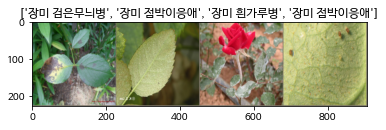

In [7]:
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_dataloader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [8]:
model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 3개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [10]:
num_epochs = 30
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#0 Loss: 0.4178 Acc: 87.5000% Time: 1.2955s
#1 Loss: 0.1711 Acc: 95.8333% Time: 2.4541s
#2 Loss: 0.3398 Acc: 91.6667% Time: 3.5373s
#3 Loss: 0.0876 Acc: 100.0000% Time: 4.7384s
#4 Loss: 0.0899 Acc: 100.0000% Time: 5.8923s
#5 Loss: 0.0578 Acc: 100.0000% Time: 6.9949s
#6 Loss: 0.0411 Acc: 100.0000% Time: 8.1290s
#7 Loss: 0.2026 Acc: 95.8333% Time: 9.3138s
#8 Loss: 0.0683 Acc: 100.0000% Time: 10.3856s
#9 Loss: 0.0715 Acc: 95.8333% Time: 11.5174s
#10 Loss: 0.3107 Acc: 83.3333% Time: 12.6265s
#11 Loss: 0.0890 Acc: 100.0000% Time: 13.8148s
#12 Loss: 0.1052 Acc: 91.6667% Time: 15.0080s
#13 Loss: 0.1691 Acc: 95.8333% Time: 16.0855s
#14 Loss: 0.0086 Acc: 100.0000% Time: 17.1553s
#15 Loss: 0.0536 Acc: 100.0000% Time: 18.2324s
#16 Loss: 0.0278 Acc: 100.0000% Time: 19.4315s
#17 Loss: 0.0538 Acc: 100.0000% Time: 20.5635s
#18 Loss: 0.0340 Acc: 100.0000% Time: 21.6409s
#19 Loss: 0.1159 Acc: 95.8333% Time: 22.7346s
#20 Loss: 0.0114 Acc: 100.0000% Time: 23.8332s
#21 Loss: 0.1206 Acc: 95.8333% Time: 24.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[예측 결과: 장미 검은무늬병] (실제 정답: 장미 검은무늬병)


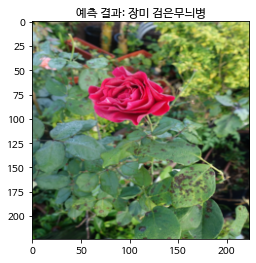

[예측 결과: 장미 점박이응애] (실제 정답: 장미 점박이응애)


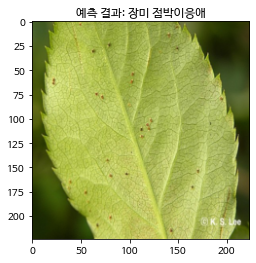

[예측 결과: 장미 점박이응애] (실제 정답: 장미 점박이응애)


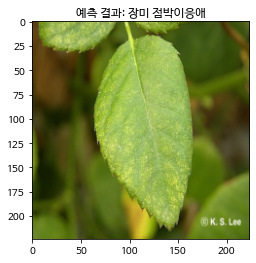

[예측 결과: 장미 흰가루병] (실제 정답: 장미 흰가루병)


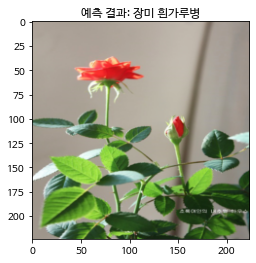

[예측 결과: 장미 흰가루병] (실제 정답: 장미 흰가루병)


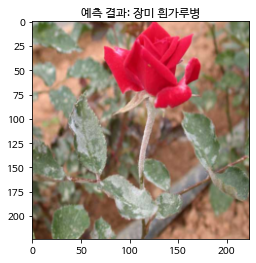

[예측 결과: 장미 흰가루병] (실제 정답: 장미 점박이응애)


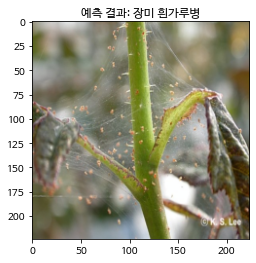

[예측 결과: 장미 점박이응애] (실제 정답: 장미 점박이응애)


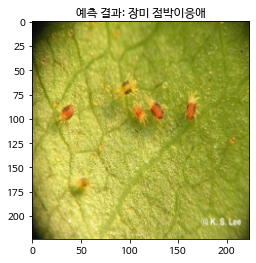

[예측 결과: 장미 흰가루병] (실제 정답: 장미 흰가루병)


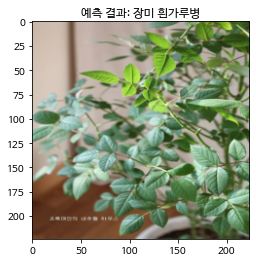

[예측 결과: 장미 검은무늬병] (실제 정답: 장미 흰가루병)


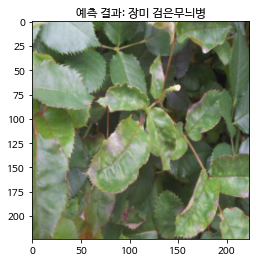

[Test Phase] Loss: 0.7989 Acc: 61.1111% Time: 3.5812s


In [11]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

In [20]:
# 테스트용 이미지 다운로드하기
!wget data: https://t1.daumcdn.net/cfile/blog/260B9F3753A3EC2308 -O test_image.jpg

--2021-12-05 13:45:24--  ftp://data/
           => ‘.listing’
Resolving data (data)... failed: No address associated with hostname.
wget: unable to resolve host address ‘data’
--2021-12-05 13:45:24--  https://t1.daumcdn.net/cfile/blog/260B9F3753A3EC2308
Resolving t1.daumcdn.net (t1.daumcdn.net)... 104.123.153.25, 104.123.153.11, 2600:1407:3c00:10::17dc:f6af, ...
Connecting to t1.daumcdn.net (t1.daumcdn.net)|104.123.153.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150347 (147K) [image/jpeg]
Saving to: ‘test_image.jpg’

test_image.jpg      100%[===================>] 146.82K   405KB/s    in 0.4s    

2021-12-05 13:45:26 (405 KB/s) - ‘test_image.jpg’ saved [150347/150347]

FINISHED --2021-12-05 13:45:26--
Total wall clock time: 1.6s
Downloaded: 1 files, 147K in 0.4s (405 KB/s)


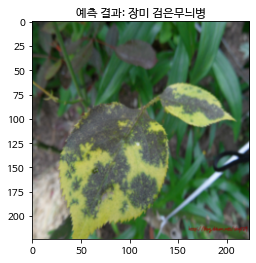

In [21]:
from PIL import Image


image = Image.open('test_image.jpg')
image = transforms_test(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(image)
    _, preds = torch.max(outputs, 1)
    imshow(image.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])